# Text Classification with Movie Reviews

## Setup

In [1]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

2023-02-27 22:59:42.953299: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Version:  2.11.0
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


## Download the IMDB dataset

The IMDB dataset is available on [TensorFlow datasets](https://github.com/tensorflow/datasets). The following code downloads the IMDB dataset to your machine (or the colab runtime):

In [2]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], 
                                  batch_size=-1, as_supervised=True)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

2023-02-27 22:59:48.821837: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Build the model

In [3]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.5423195 , -0.0119017 ,  0.06337538,  0.06862972, -0.16776837,
        -0.10581174,  0.16865303, -0.04998824, -0.31148055,  0.07910346,
         0.15442263,  0.01488662,  0.03930153,  0.19772711, -0.12215476,
        -0.04120981, -0.2704109 , -0.21922152,  0.26517662, -0.80739075,
         0.25833532, -0.3100421 ,  0.28683215,  0.1943387 , -0.29036492,
         0.03862849, -0.7844411 , -0.0479324 ,  0.4110299 , -0.36388892,
        -0.58034706,  0.30269456,  0.3630897 , -0.15227164, -0.44391504,
         0.19462997,  0.19528408,  0.05666234,  0.2890704 , -0.28468323,
        -0.00531206,  0.0571938 , -0.3201318 , -0.04418665, -0.08550783,
        -0.55847436, -0.23336391, -0.20782952, -0.03543064, -0.17533456],
       [ 0.56338924, -0.12339553, -0.10862679,  0.7753425 , -0.07667089,
        -0.15752277,  0.01872335, -0.08169781, -0.3521876 ,  0.4637341 ,
        -0.08492756,  0.07166859, -0.00670817,  0.12686075, -0.19326553,
 

Let's now build the full model:

In [4]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Build the mechanized model

In [5]:
import sys
sys.path.append("..")

from mechanism.mechanized_sequential import MechanizedSequential
from mechanism.mechanized_sequential import Mechanism
EPOCH = 5


mechanized_model = MechanizedSequential()
mechanized_model.add(hub_layer)
mechanized_model.add(tf.keras.layers.Dense(16, activation='relu'))
mechanized_model.add(tf.keras.layers.Dense(1))


In [6]:
mechanized_model.choose_mech(Mechanism.GAUSSIAN)
mechanized_model.set_mechanism_para(sigma = 0.1)
mechanized_model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')],
              run_eagerly = True)

In [7]:
x_val = train_examples[:10000]
partial_x_train = train_examples[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [13]:


gaussian_history = mechanized_model.fit(partial_x_train,
                    partial_y_train,
                    epochs = EPOCH,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
30/30 [==============================] - 42s 1s/step - loss: 0.2008 - accuracy: 0.9324 - val_loss: 0.3110 - val_accuracy: 0.8669
Epoch 2/5
30/30 [==============================] - 40s 1s/step - loss: 0.1543 - accuracy: 0.9536 - val_loss: 0.3036 - val_accuracy: 0.8711
Epoch 3/5
30/30 [==============================] - 44s 1s/step - loss: 0.1169 - accuracy: 0.9701 - val_loss: 0.3068 - val_accuracy: 0.8715
Epoch 4/5
30/30 [==============================] - 40s 1s/step - loss: 0.0894 - accuracy: 0.9801 - val_loss: 0.3089 - val_accuracy: 0.8726
Epoch 5/5
30/30 [==============================] - 40s 1s/step - loss: 0.0646 - accuracy: 0.9891 - val_loss: 0.3131 - val_accuracy: 0.8743


In [14]:
results = mechanized_model.evaluate(test_examples, test_labels)

print(results)

782/782 [==============================] - 100s 128ms/step - loss: 0.6562 - accuracy: 0.8441
[0.6561796069145203, 0.8440799713134766]


In [10]:
mechanized_model.choose_mech(Mechanism.THRESHOLD)
mechanized_model.set_mechanism_para(sigma = 0.1, hold_frac = 0.4, threshold = 0.5)


mechanized_model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')],
              run_eagerly = True)

In [11]:
threshold_history = mechanized_model.fit(partial_x_train,
                    partial_y_train,
                    epochs = EPOCH,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
In Threshold out Mechanism
0.021938099
 1/30 [>.............................] - ETA: 37s - loss: 0.6890 - accuracy: 0.5422In Threshold out Mechanism
0.022666909
 2/30 [=>............................] - ETA: 41s - loss: 0.6853 - accuracy: 0.5536In Threshold out Mechanism
0.0130781755
 3/30 [==>...........................] - ETA: 39s - loss: 0.6844 - accuracy: 0.5498In Threshold out Mechanism
0.011037692
 4/30 [===>..........................] - ETA: 36s - loss: 0.6843 - accuracy: 0.5519In Threshold out Mechanism
0.01911816
 5/30 [====>.........................] - ETA: 36s - loss: 0.6829 - accuracy: 0.5578In Threshold out Mechanism
0.019155286
 6/30 [=====>........................] - ETA: 34s - loss: 0.6831 - accuracy: 0.5557In Threshold out Mechanism
0.018065795
 7/30 [======>.......................] - ETA: 32s - loss: 0.6819 - accuracy: 0.5603In Threshold out Mechanism
0.05439832
 8/30 [=======>......................] - ETA: 30s - loss: 0.6807 - accuracy: 0.5601In Threshold ou

In [12]:
results = mechanized_model.evaluate(test_examples, test_labels)

print(results)

782/782 [==============================] - 101s 129ms/step - loss: 0.3459 - accuracy: 0.8502
[0.3459072709083557, 0.8501999974250793]


In [15]:
mechanized_model.choose_mech(None)

mechanized_model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [17]:
empirical_history = mechanized_model.fit(partial_x_train,
                    partial_y_train,
                    epochs = EPOCH,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
30/30 [==============================] - 27s 906ms/step - loss: 0.0336 - accuracy: 0.9959 - val_loss: 0.3461 - val_accuracy: 0.8727
Epoch 2/5
30/30 [==============================] - 24s 786ms/step - loss: 0.0217 - accuracy: 0.9979 - val_loss: 0.3648 - val_accuracy: 0.8706
Epoch 3/5
30/30 [==============================] - 23s 780ms/step - loss: 0.0144 - accuracy: 0.9991 - val_loss: 0.3823 - val_accuracy: 0.8706
Epoch 4/5
30/30 [==============================] - 23s 776ms/step - loss: 0.0098 - accuracy: 0.9994 - val_loss: 0.3996 - val_accuracy: 0.8689
Epoch 5/5
30/30 [==============================] - 24s 807ms/step - loss: 0.0069 - accuracy: 0.9998 - val_loss: 0.4161 - val_accuracy: 0.8686


In [18]:
results = mechanized_model.evaluate(test_examples, test_labels)

print(results)

782/782 [==============================] - 100s 128ms/step - loss: 0.4711 - accuracy: 0.8520
[0.47110265493392944, 0.8520399928092957]


## Visualization

In [23]:
def visualization(history, mechanism = "Baseline"):
    history_dict = history.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)

    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'bo', label='Training loss: ' + mechanism)
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss' + mechanism)
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()


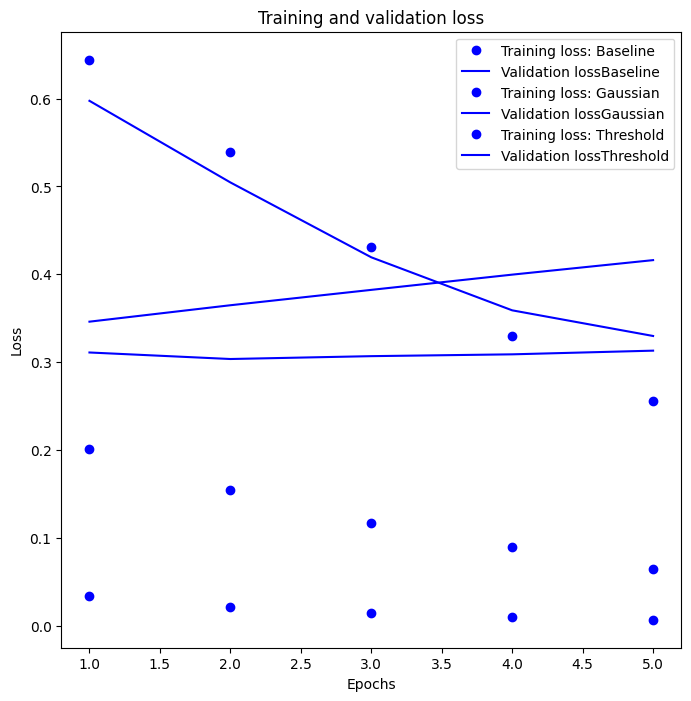

In [24]:
plt.figure(figsize=(8, 8))
visualization(empirical_history)
visualization(gaussian_history, "Gaussian")
visualization(threshold_history, "Threshold")
plt.show()

In [26]:
def visualization_val(history, mechanism = "Baseline"):
    history_dict = history.history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']

    epochs = range(1, len(acc) + 1)

    plt.clf()   # clear figure

    plt.plot(epochs, acc, 'bo', label='Training acc' + mechanism)
    plt.plot(epochs, val_acc, 'b', label='Validation acc ' + mechanism)
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()



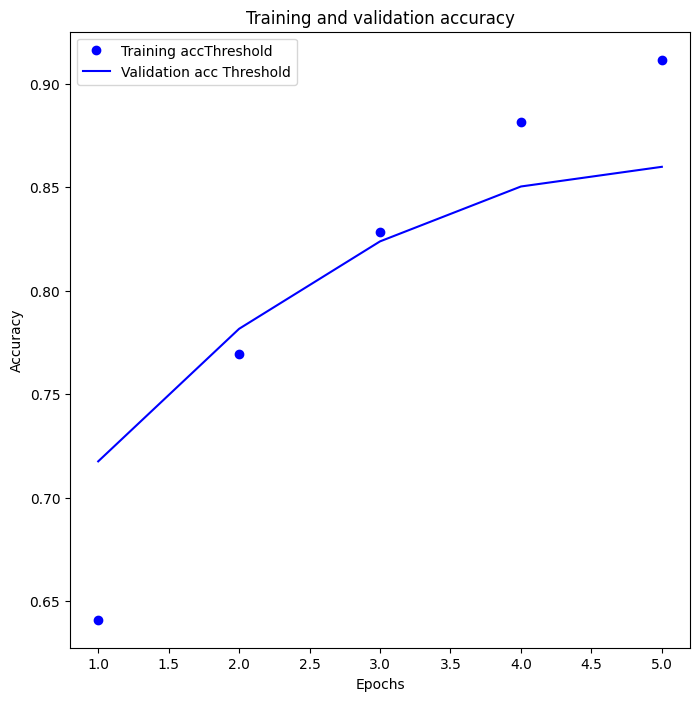

In [27]:
plt.figure(figsize=(8, 8))
visualization_val(empirical_history)
visualization_val(gaussian_history, "Gaussian")
visualization_val(threshold_history, "Threshold")
plt.show()